In [1]:
!pip install pymorphy2

     |████████████████████████████████| 55 kB 2.9 MB/s 
     |████████████████████████████████| 8.2 MB 21.9 MB/s 


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re
import pymorphy2
import nltk
from tqdm import tqdm
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, RandomForestRegressor
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import f1_score, accuracy_score, roc_auc_score
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [3]:
articles = pd.read_csv('articles.csv', sep=';', encoding='utf-8')

In [4]:
articles.head(10)

,title,year,authors,link,ВАК,Scopus,ECSI,RSCI,theme
0,THE ASSOTIATION OF PERSONALITY DISORDERS AND L...,2021,[' Krsteska R.'],https://cyberleninka.ru//article/n/the-assotia...,1,0,0,0,Фундаментальная медицина
1,СИМУЛЯЦИОННЫЙ КУРС КАК ОСНОВА ПОДГОТОВКИ СПЕЦИ...,2021,"[' Таиров В.В.', ' Адамчик А.А.', ' Камышников...",https://cyberleninka.ru//article/n/simulyatsio...,1,0,0,0,Фундаментальная медицина
2,ИССЛЕДОВАНИЕ ПРОИЗВОДНОГО 3-ОКСИПИРИДИНА НА БЕ...,2021,"[' Трескунова Е.В.', ' Свиридонова С.В.']",https://cyberleninka.ru//article/n/issledovani...,1,0,0,0,Фундаментальная медицина
3,ВОПРОСЫ БЕЗОПАСНОСТИ РАЗРАБОТАННОЙ СУСПЕНЗИИ П...,2021,"[' Илькевич Е.В.', ' Воронков А.В.', ' Степано...",https://cyberleninka.ru//article/n/voprosy-bez...,1,0,0,0,Фундаментальная медицина
4,РАЗРАБОТКА И ВАЛИДАЦИЯ ВЭЖХ-МС/МС МЕТОДИКИ КОЛ...,2021,"[' Шестакова К.М.', ' Москалева Н.Е.', ' Месон...",https://cyberleninka.ru//article/n/razrabotka-...,1,0,0,0,Фундаментальная медицина
5,ПРИМЕНЕНИЕ УЛЬТРАФИЛЬТРАЦИОННЫХ МЕМБРАН ДЛЯ ОЧ...,2021,"[' Ковпак А.А.', ' Ивин Ю.Ю.', ' Пиняева А.Н.'...",https://cyberleninka.ru//article/n/primenenie-...,1,0,0,1,Фундаментальная медицина
6,ВЛИЯНИЕ ИММУНОМОДУЛЯЦИИ НА ВНУТРИКЛЕТОЧНУЮ ЭКС...,2021,"[' Клюева С.Н.', ' Гончарова А.Ю.', ' Кравцов ...",https://cyberleninka.ru//article/n/vliyanie-im...,1,0,0,1,Фундаментальная медицина
7,АССОЦИАЦИЯ УВЕЛИЧЕНИЯ КОЛИЧЕСТВА ЦИРКУЛИРУЮЩИХ...,2021,"[' Долгушин И.И.', ' Генкель В.В.', ' Батурина...",https://cyberleninka.ru//article/n/assotsiatsi...,1,0,0,1,Фундаментальная медицина
8,ДЕСЯТИЛЕТНЕЕ НАБЛЮДЕНИЕ ЗА СЕНСИБИЛИЗАЦИЕЙ К К...,2021,"[' Петрова С.Ю.', ' Хлгатян С.В.', ' Бержец В....",https://cyberleninka.ru//article/n/desyatiletn...,1,0,0,1,Фундаментальная медицина
9,СОВРЕМЕННАЯ СТРАТЕГИЯ КОНТРОЛЯ ВИРУСНОГО ГЕПАТ...,2021,"[' Михайлов М.И.', ' Кюрегян К.К.']",https://cyberleninka.ru//article/n/sovremennay...,1,0,0,1,Фундаментальная медицина


Посмотрим, сколько статей каждой темы находятся в датасете:

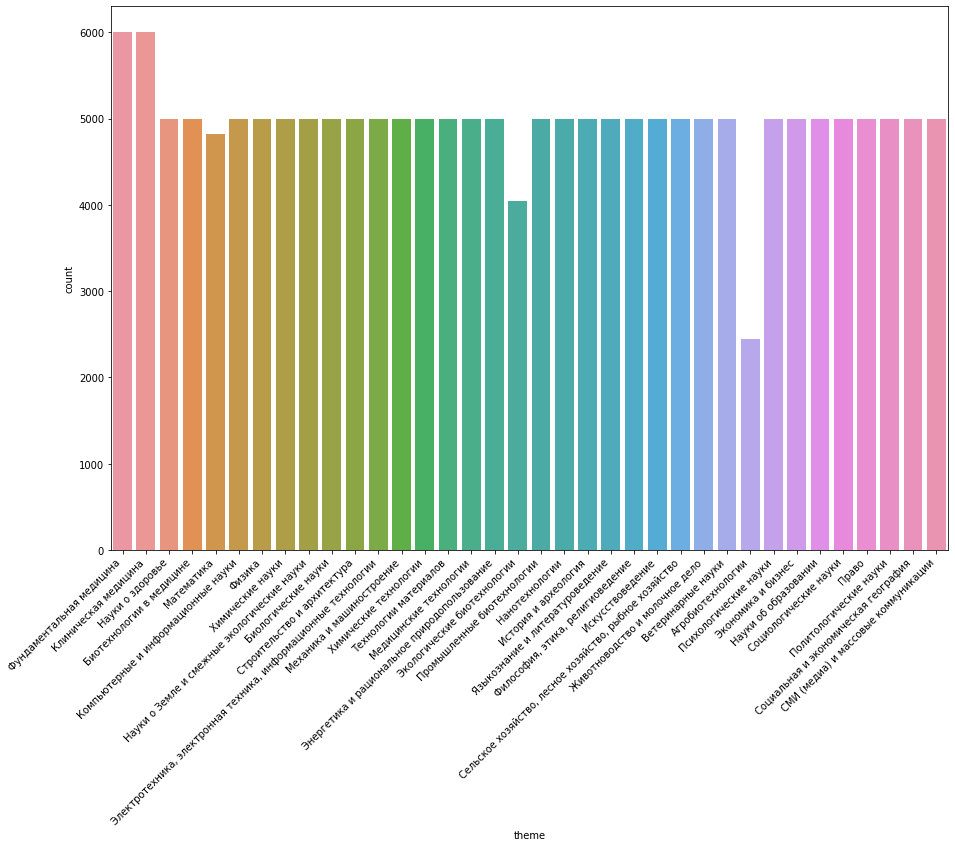

In [5]:
f, ax = plt.subplots(figsize=(15, 10))
chart = sns.countplot(data=articles, x='theme')
ch = chart.set_xticklabels(chart.get_xticklabels(), rotation=45, horizontalalignment='right')

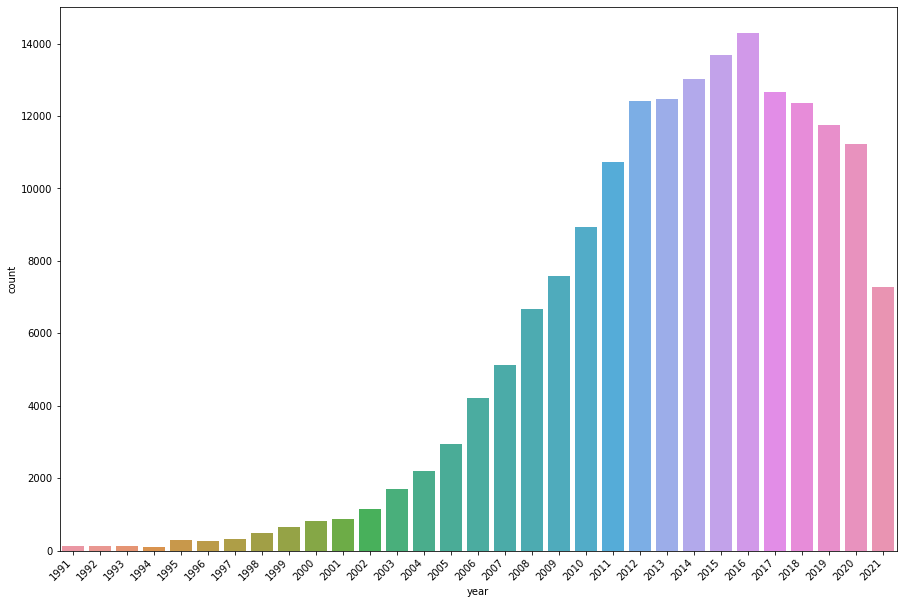

In [6]:
f, ax = plt.subplots(figsize=(15, 10))
chart = sns.countplot(data=articles[articles.year > 1990], x='year')
ch = chart.set_xticklabels(chart.get_xticklabels(), rotation=45, horizontalalignment='right')

In [7]:
TOKEN_PATTERN = "[А-ЯЁа-яёA-Za-z]+"
def tokenize(text):
    return re.findall(TOKEN_PATTERN, text.lower())

In [8]:
corpus = articles.title.values

In [9]:
docs = [tokenize(title) for title in corpus]

In [10]:
#sw = set(['ru', 'mail', 'mp', 'com', 'страница', 'org', 'gp', 'net'])
stopword_set_ru = nltk.corpus.stopwords.words('russian')
stopword_set_eng = set(nltk.corpus.stopwords.words('english'))
stopwords = stopword_set_eng.union(stopword_set_ru)

In [11]:
lemmatizer = pymorphy2.MorphAnalyzer()

In [12]:
lemmatizer_cache = {}

def lemmatize(token):
    if lemmatizer.word_is_known(token):
        if token not in lemmatizer_cache:
            lemmatizer_cache[token] = lemmatizer.parse(token)[0].normal_form
        return lemmatizer_cache[token]
    return token

lemmatized_docs = [[lemmatize(token) for token in text] for text in tqdm(docs)]

cleared_docs = [[token for token in text if token not in stopwords] for text in lemmatized_docs]

100%|██████████| 178293/178293 [01:30<00:00, 1971.22it/s]


In [13]:
def conect(array):
    string = ""
    for i in range(len(array)):
        string += str(array[i])+' '
    return string.rstrip()

In [14]:
df = pd.DataFrame({"title": cleared_docs})

In [15]:
df = df["title"].apply(conect)

In [16]:
articles.title = df

In [17]:
articles

,title,year,authors,link,ВАК,Scopus,ECSI,RSCI,theme
0,assotiation personality disorders late life de...,2021,[' Krsteska R.'],https://cyberleninka.ru//article/n/the-assotia...,1,0,0,0,Фундаментальная медицина
1,симуляционный курс основа подготовка специалис...,2021,"[' Таиров В.В.', ' Адамчик А.А.', ' Камышников...",https://cyberleninka.ru//article/n/simulyatsio...,1,0,0,0,Фундаментальная медицина
2,исследование производный оксипиридина белковоо...,2021,"[' Трескунова Е.В.', ' Свиридонова С.В.']",https://cyberleninka.ru//article/n/issledovani...,1,0,0,0,Фундаментальная медицина
3,вопрос безопасность разработать суспензия пиро...,2021,"[' Илькевич Е.В.', ' Воронков А.В.', ' Степано...",https://cyberleninka.ru//article/n/voprosy-bez...,1,0,0,0,Фундаментальная медицина
4,разработка валидация вэжх мс мс методика колич...,2021,"[' Шестакова К.М.', ' Москалева Н.Е.', ' Месон...",https://cyberleninka.ru//article/n/razrabotka-...,1,0,0,0,Фундаментальная медицина
...,...,...,...,...,...,...,...,...,...
178288,особенность работа сми советский постсоветский...,2013,[' Касаткин Сергей Сергеевич'],https://cyberleninka.ru//article/n/osobennosti...,1,0,0,0,СМИ (медиа) и массовые коммуникации
178289,подросток интернет среда общение чтение поведение,2013,[' Губанова Александра Юрьевна'],https://cyberleninka.ru//article/n/podrostki-v...,1,0,0,0,СМИ (медиа) и массовые коммуникации
178290,социальный картографирование эволюция метод,2013,[' Стрельникова Анна Владимировна'],https://cyberleninka.ru//article/n/sotsialnoe-...,1,0,0,0,СМИ (медиа) и массовые коммуникации
178291,специфика метод медиаметрических исследование ...,2012,[' Попов Владимир Владимирович'],https://cyberleninka.ru//article/n/spetsifika-...,1,0,0,0,СМИ (медиа) и массовые коммуникации


In [18]:
from sklearn.preprocessing import LabelEncoder

In [19]:
le = LabelEncoder()

In [ ]:
le.fit(articles.theme)

LabelEncoder()

In [ ]:
articles.theme = le.transform(articles.theme)

In [ ]:
data = articles['title']

In [ ]:
data

0         assotiation personality disorders late life de...
1         симуляционный курс основа подготовка специалис...
2         исследование производный оксипиридина белковоо...
3         вопрос безопасность разработать суспензия пиро...
4         разработка валидация вэжх мс мс методика колич...
                                ...                        
178288    особенность работа сми советский постсоветский...
178289    подросток интернет среда общение чтение поведение
178290          социальный картографирование эволюция метод
178291    специфика метод медиаметрических исследование ...
178292    аудитория современный московский театр социоку...
Name: title, Length: 178293, dtype: object

### Baseline

Baseline-модель на одном признаке - тексте названия статьи.

In [ ]:
data_train, df_val = train_test_split(data, test_size=0.2, random_state=42)

In [ ]:
y = articles["theme"].astype(int).values
y_train, y_val = train_test_split(y, test_size=0.2, random_state=42)

In [59]:
from sklearn.base import TransformerMixin

class ColumnExtractor(TransformerMixin):
    
    def __init__(self, column_name):
        self.column_name = column_name
    
    def fit(self, X, y=None):
        return self
    
    def transform(self, X, y=None):
        return X[self.column_name].values

In [60]:
from sklearn.ensemble import VotingClassifier

In [62]:
pipeline = Pipeline([
    (
        'features', 
        FeatureUnion([
            (
                  'vectorizer', 
                  TfidfVectorizer(lowercase=True, ngram_range=(1, 1),
                        min_df=5, max_df=0.9)  
            )
        ])
    ),
    ('clf', VotingClassifier(estimators = [('forest', RandomForestClassifier(n_estimators=100,
                                                                         min_samples_leaf=1,
                                                                         random_state=42,
                                                                         max_features='sqrt',
                                                                         class_weight = 'balanced',
                                                                         n_jobs=None)),
                                       ('logreg', LogisticRegression(random_state=42,
                                                                     solver="liblinear", 
                                                                     class_weight='balanced',
                                                                     max_iter=1000, 
                                                                     C=5.0)),
                                      ],
                         voting='soft',
                         n_jobs=None))
])

In [ ]:
pipeline.fit(data_train, y_train)

Pipeline(steps=[('features',
                 FeatureUnion(transformer_list=[('vectorizer',
                                                 CountVectorizer(max_df=0.9,
                                                                 min_df=5))])),
                ('clf',
                 VotingClassifier(estimators=[('forest',
                                               RandomForestClassifier(class_weight='balanced',
                                                                      max_features='sqrt',
                                                                      random_state=42)),
                                              ('logreg',
                                               LogisticRegression(C=5.0,
                                                                  class_weight='balanced',
                                                                  max_iter=1000,
                                                                  random_state=42,
          

In [64]:
from sklearn.metrics import f1_score

In [ ]:
y_pred = pipeline.predict(df_val)

In [ ]:
f1_score(
    y_val,
    y_pred,
    average = 'micro'
)

0.5724781962477916

In [ ]:
accuracy_score(
    y_val,
    y_pred
  )

0.5724781962477916

Как можно заметить, предсказательная способность модели, построенной на одном признаке, мягко говоря, оставляет желать лучшего. Для решения этой проблемы в рамках задачи можно попробовать:
- Сократить количство классов (обучать не на 36 углубленных темах, а на 6 более общих);
- Добавить другие признаки, например можно сгенерировать признак - соотношение полов авторов статьи;
- Обучить модель не на названиях статей, а на тексте самих статей (этот вариант потребует значительно большую вычислительную мощность чем для обучения только на названиях)

In [43]:
head = pd.read_csv("head.csv", sep=';', encoding='1251').drop(['link'], axis=1)

In [44]:
head

,main_theme,theme
0,Медицинские науки,Фундаментальная медицина
1,Медицинские науки,Клиническая медицина
2,Медицинские науки,Науки о здоровье
3,Медицинские науки,Биотехнологии в медицине
4,Естественные и точные науки,Математика
5,Естественные и точные науки,Компьютерные и информационные науки
6,Естественные и точные науки,Физика
7,Естественные и точные науки,Химические науки
8,Естественные и точные науки,Науки о Земле и смежные экологические науки
9,Естественные и точные науки,Биологические науки


In [46]:
join = pd.merge(head, articles, 'inner')

In [47]:
join

,main_theme,theme,title,year,authors,link,ВАК,Scopus,ECSI,RSCI
0,Медицинские науки,Фундаментальная медицина,assotiation personality disorders late life de...,2021,[' Krsteska R.'],https://cyberleninka.ru//article/n/the-assotia...,1,0,0,0
1,Медицинские науки,Фундаментальная медицина,симуляционный курс основа подготовка специалис...,2021,"[' Таиров В.В.', ' Адамчик А.А.', ' Камышников...",https://cyberleninka.ru//article/n/simulyatsio...,1,0,0,0
2,Медицинские науки,Фундаментальная медицина,исследование производный оксипиридина белковоо...,2021,"[' Трескунова Е.В.', ' Свиридонова С.В.']",https://cyberleninka.ru//article/n/issledovani...,1,0,0,0
3,Медицинские науки,Фундаментальная медицина,вопрос безопасность разработать суспензия пиро...,2021,"[' Илькевич Е.В.', ' Воронков А.В.', ' Степано...",https://cyberleninka.ru//article/n/voprosy-bez...,1,0,0,0
4,Медицинские науки,Фундаментальная медицина,разработка валидация вэжх мс мс методика колич...,2021,"[' Шестакова К.М.', ' Москалева Н.Е.', ' Месон...",https://cyberleninka.ru//article/n/razrabotka-...,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...
178288,Социальные науки,СМИ (медиа) и массовые коммуникации,особенность работа сми советский постсоветский...,2013,[' Касаткин Сергей Сергеевич'],https://cyberleninka.ru//article/n/osobennosti...,1,0,0,0
178289,Социальные науки,СМИ (медиа) и массовые коммуникации,подросток интернет среда общение чтение поведение,2013,[' Губанова Александра Юрьевна'],https://cyberleninka.ru//article/n/podrostki-v...,1,0,0,0
178290,Социальные науки,СМИ (медиа) и массовые коммуникации,социальный картографирование эволюция метод,2013,[' Стрельникова Анна Владимировна'],https://cyberleninka.ru//article/n/sotsialnoe-...,1,0,0,0
178291,Социальные науки,СМИ (медиа) и массовые коммуникации,специфика метод медиаметрических исследование ...,2012,[' Попов Владимир Владимирович'],https://cyberleninka.ru//article/n/spetsifika-...,1,0,0,0


In [48]:
le.fit(join.main_theme)

LabelEncoder()

In [49]:
join.main_theme = le.transform(join.main_theme)

In [54]:
data = join['title']

In [55]:
data

0         assotiation personality disorders late life de...
1         симуляционный курс основа подготовка специалис...
2         исследование производный оксипиридина белковоо...
3         вопрос безопасность разработать суспензия пиро...
4         разработка валидация вэжх мс мс методика колич...
                                ...                        
178288    особенность работа сми советский постсоветский...
178289    подросток интернет среда общение чтение поведение
178290          социальный картографирование эволюция метод
178291    специфика метод медиаметрических исследование ...
178292    аудитория современный московский театр социоку...
Name: title, Length: 178293, dtype: object

In [56]:
data_train, df_val = train_test_split(data, test_size=0.2, random_state=42)

In [57]:
y = join["main_theme"].astype(int).values
y_train, y_val = train_test_split(y, test_size=0.2, random_state=42)

In [63]:
pipeline.fit(data_train, y_train)

Pipeline(steps=[('features',
                 FeatureUnion(transformer_list=[('vectorizer',
                                                 TfidfVectorizer(max_df=0.9,
                                                                 min_df=5))])),
                ('clf',
                 VotingClassifier(estimators=[('forest',
                                               RandomForestClassifier(class_weight='balanced',
                                                                      max_features='sqrt',
                                                                      random_state=42)),
                                              ('logreg',
                                               LogisticRegression(C=5.0,
                                                                  class_weight='balanced',
                                                                  max_iter=1000,
                                                                  random_state=42,
          

In [65]:
y_pred = pipeline.predict(df_val)

In [66]:
f1_score(
    y_val,
    y_pred,
    average = 'micro'
)

0.7727642390420371

In [67]:
accuracy_score(
    y_val,
    y_pred
  )

0.7727642390420371